In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)


Number of replicas: 1
2.12.0


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 6 * strategy.num_replicas_in_sync
IMAGE_SIZE = [299, 299]
EPOCHS = 25

In [3]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd MyDrive

Mounted at /gdrive
/gdrive
/gdrive/MyDrive


In [5]:
GCS_PATH = 'chest_xray'

In [6]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_bacteria = len([filename for filename in train_filenames if "bacteria" in filename])
print("Bacteria images count in training set: " + str(COUNT_bacteria))

COUNT_virus = len([filename for filename in train_filenames if "virus" in filename])
print("Virus images count in training set: " + str(COUNT_virus))

Normal images count in training set: 1100
Bacteria images count in training set: 2006
Virus images count in training set: 1094


In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'chest_xray/train/NORMAL/IM-0119-0001.jpeg'
b'chest_xray/train/PNEUMONIA/person23_bacteria_105.jpeg'
b'chest_xray/train/PNEUMONIA/person398_bacteria_1801.jpeg'
b'chest_xray/train/PNEUMONIA/person1597_bacteria_4187.jpeg'
b'chest_xray/train/PNEUMONIA/person425_bacteria_1860.jpeg'


In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4200
Validating images count: 1050


In [10]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "/chest_xray/train/*"))])
CLASS_NAMES

array([], dtype=float64)

**Augmentation**

In [11]:
augment = tf.keras.Sequential([
  tf.keras.layers.Resizing(*IMAGE_SIZE),
  tf.keras.layers.RandomZoom(height_factor=(-0.05, -0.15),width_factor=(-0.05, -0.15)),
	tf.keras.layers.RandomRotation(0.1),
])

In [12]:
# def get_label(file_path):
#     # convert the path to a list of path components
#     parts = tf.strings.split(file_path, os.path.sep)
#     # The second to last is the class-directory
#     return parts[-2]

def get_label(file_path):
    # Extract the file name from the file path
    file_name = tf.strings.split(file_path, os.path.sep)[-1]

    # Check if the file name contains "virus" or "bacteria"
    is_virus = tf.strings.regex_full_match(file_name, r'.*virus.*')
    is_bacteria = tf.strings.regex_full_match(file_name, r'.*bacteria.*')

    # Assign labels based on file name conditions
    label = tf.cond(is_virus, lambda: "virus",
                    lambda: tf.cond(is_bacteria, lambda: "bacteria", lambda: "NORMAL"))

    return label

In [13]:
def decode_img(img, augmentation=False):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  if augmentation:
    return augment(img)
  
  return tf.image.resize(img,IMAGE_SIZE)

In [14]:
def process_path(file_path, augmentation=False):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img, augmentation)
    labels = [int(label == "virus"), int(label=="bacteria"), int(label == "NORMAL")]
    labels.extend([0] * 997)
    return img, labels

In [15]:
train_ds = train_list_ds.map(partial(process_path, augmentation=False), num_parallel_calls=AUTOTUNE)
# train_ds_aug = train_list_ds.map(partial(process_path, augmentation=True), num_parallel_calls=AUTOTUNE)
# train_ds = tf.data.Dataset.concatenate(train_ds, train_ds_aug)

val_ds = val_list_ds.map(partial(process_path, augmentation=False), num_parallel_calls=AUTOTUNE)
# val_ds_aug = val_list_ds.map(partial(process_path, augmentation=True), num_parallel_calls=AUTOTUNE)
# val_ds = tf.data.Dataset.concatenate(val_ds, val_ds_aug)


In [16]:
# train_ds_length = tf.data.experimental.cardinality(train_ds).numpy()
# print("Number of images in train_ds:", train_ds_length)

In [17]:
# train_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/train/*/*'))
# tf.data.experimental.cardinality(train_list_ds).numpy()

In [18]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (299, 299, 3)
Label:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [19]:
test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

In [20]:
def prepare_for_training(ds, cache=False, shuffle_buffer_size=500):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [21]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [22]:
# print(label_batch)
print(label_batch.shape)
print(image_batch.shape)

(6, 1000)
(6, 299, 299, 3)


In [23]:
def show_batch(image_batch, label_batch):
    fig, imgs = plt.subplots(BATCH_SIZE//4,4)
    fig.tight_layout()
    fig.set_figwidth(8) 
    for n in range(BATCH_SIZE):
      imgs[n//4][n%4].imshow(image_batch[n])
      if label_batch[n][0]:
        imgs[n//4][n%4].set_title("PNEUMONIA")
      else:
        imgs[n//4][n%4].set_title("NORMAL")

In [24]:
# show_batch(image_batch.numpy(), label_batch.numpy())

In [25]:
bacterial_bias = np.log([COUNT_bacteria/COUNT_NORMAL])
virus_bias = np.log([COUNT_virus/COUNT_NORMAL])
print(bacterial_bias, virus_bias)

[0.60083251] [-0.00546948]


In [26]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/3.0 
weight_for_1 = (1 / COUNT_bacteria)*(TRAIN_IMG_COUNT)/3.0
weight_for_2 = (1 / COUNT_virus)*(TRAIN_IMG_COUNT)/3.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 1.27
Weight for class 1: 0.70
Weight for class 2: 1.28


In [27]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import os

def reformat(labels, number = 10) :
    array = np.zeros((labels.shape[0], number))
    i = 0
    for label in labels :
        array[i][label] = 1
        i += 1
    return array

def loadData() :
    (x_train, y_train_basic), (x_test, y_test_basic) = tf.keras.datasets.cifar10.load_data()
    y_train = reformat(y_train_basic)
    y_test = reformat(y_test_basic)
    return x_train, y_train, x_test, y_test, y_train_basic, y_test_basic

def optimizeModel(model, train_ds, val_ds, epochs = 150) :
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss=tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'], jit_compile = True)
    history = model.fit(train_ds, batch_size = 64, epochs = epochs, steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE, validation_data=val_ds, validation_steps=VAL_IMG_COUNT // BATCH_SIZE)
    return model, history

def plotHistory(history) :
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower left')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0,1.1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(np.array(val_loss) / 10, label='Validation Loss')
    plt.legend(loc='lower left')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.show()


def test(model, train_ds, test_ds, val_ds, doPlot = True, doEvaluate = True, epochs = 150) :
    model, history = optimizeModel(model, train_ds, val_ds, epochs = epochs)
    if doEvaluate : model.evaluate(test_ds)
    if doPlot : plotHistory(history)
    return model

def prepareXception(train_ds, test_ds, val_ds, model, doFreeze = True, epochs = 150) :
    for layer in model.layers :
      if doFreeze or layer.name[:5] == "batch" :
          layer.trainable = False
      else :
          layer.trainable = True
    if doFreeze :
        model.layers[-2] = tf.keras.layers.GlobalAveragePooling2D()
        model.layers[-1] = tf.keras.layers.Dense(units = 2, activation = 'softmax')
    model.layers[-2].trainable = True
    model.layers[-1].trainable = True
    
    return test(model, train_ds, test_ds, val_ds, doPlot = True, doEvaluate = True, epochs = epochs)

def step3(train_ds, test_ds, val_ds, doFreeze = True, epochs = 40, doPredict = True) :
    model = tf.keras.applications.Xception(include_top=True, weights="imagenet", input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation="softmax")
    model = prepareXception(train_ds, test_ds, val_ds, model, doFreeze, epochs)
    return model

91884032/91884032 [==============================] - 8s 0us/step
Epoch 1/50
700/700 [==============================] - 617s 848ms/step - loss: 0.9185 - accuracy: 0.6969 - val_loss: 0.5478 - val_accuracy: 0.7829
Epoch 2/50
700/700 [==============================] - 100s 143ms/step - loss: 0.5421 - accuracy: 0.7848 - val_loss: 0.5207 - val_accuracy: 0.7810
Epoch 3/50
700/700 [==============================] - 114s 163ms/step - loss: 0.5111 - accuracy: 0.7900 - val_loss: 0.4921 - val_accuracy: 0.7971
Epoch 4/50
700/700 [==============================] - 99s 142ms/step - loss: 0.4894 - accuracy: 0.7921 - val_loss: 0.4904 - val_accuracy: 0.7876
Epoch 5/50
700/700 [==============================] - 116s 167ms/step - loss: 0.4822 - accuracy: 0.7976 - val_loss: 0.4827 - val_accuracy: 0.7914
Epoch 6/50
700/700 [==============================] - 112s 160ms/step - loss: 0.4695 - accuracy: 0.8019 - val_loss: 0.4795 - val_accuracy: 0.7895
Epoch 7/50
700/700 [==============================] - 112s 1

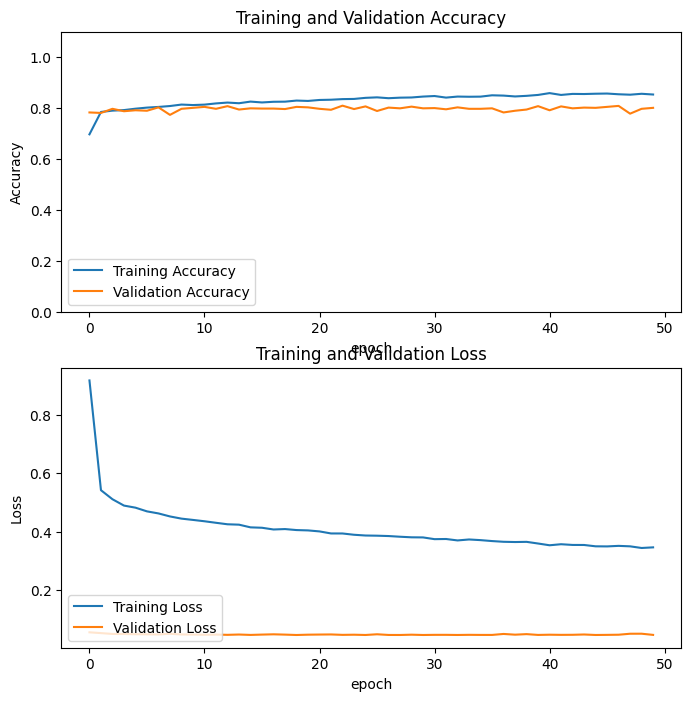

In [28]:
model, y_test, x_test = None, None, None

if __name__ == "__main__" :
    model__y_test__x_test = step3(train_ds, test_ds, val_ds, doFreeze = True, epochs = 50)